##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
orig_df = pd.read_csv('./datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
df = pd.read_csv('./datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [4]:
df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [5]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [6]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


1. **Exploring Data and Explanations:**

In [7]:
print(df.head())

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  


   Explanations:
   - `X (Latitude)`: Latitude of the reported incident.
   - `Y (Longitude)`: Longitude of the reported incident.
   - `Area_Command`: Police designation of the bureau of the operation (categorized as integers).
   - `NIBRSOffenseCode`: Classification code for the crime committed (categorized as integers).
   - `DayOfWeek`: Day of the week (categorized as integers, e.g., 0 for Sunday).
   - `Time`: Hour of the day (categorized as integers, e.g., 0 for midnight).
   - `VictimCount`: Number of persons involved in the incident.
   
   2. **Identifying Variables:**
      - **Input Variables:** Latitude (X), Longitude (Y), Hour of the day (Time), Day of the week (DayOfWeek), Area-of-command code (Area_Command), Classification code for the crime committed (NIBRSOffenseCode).
      - **Target Variable:** Number of persons involved in the incident (VictimCount).
      

   3. **Data Range and Preprocessing:**
         - Latitude (X) and Longitude (Y) : represents geographical coordinates and may have a wide range of values depending on the area. It's common to scale these values to a smaller range, such as [0, 1] or [-1, 1].
       - Time has values from 0 to 23, representing the 24 hours of a day.
       - DayOfWeek has values from 0 to 6, representing the days of the week (0 for Sunday, 1 for Monday, and so on).
       - Area_Command and NIBRSOffenseCode are categorical variables, factorized into integers.
       - VictimCount represents the number of persons involved in the incident and can vary widely ranging from 0 to a higher number.
       - For numerical features like Time, DayOfWeek, and VictimCount, consider scaling or normalizing them based on your machine learning model's requirements. Standardization or Min-Max scaling are common approaches.



## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [8]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split

# Assuming df is your preprocessed dataframe with input and target variables

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        input_data = self.data.iloc[index, :-1].values
        target = self.data.iloc[index, -1]
        return torch.tensor(input_data, dtype=torch.float), torch.tensor(target, dtype=torch.float)

# Split the dataset into training and testing subsets
train_size = int(0.8 * len(df))  # 80% for training, 20% for testing
test_size = len(df) - train_size
train_dataset, test_dataset = random_split(CustomDataset(df), [train_size, test_size])

# Define batch size
batch_size = 64

# Create DataLoader objects for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the shape of data by iterating over one dataset
for inputs, targets in train_loader:
    print("Training Batch Shape - Inputs: {}, Targets: {}".format(inputs.shape, targets.shape))
    break  # Break after the first batch to avoid printing too much

for inputs, targets in test_loader:
    print("Testing Batch Shape - Inputs: {}, Targets: {}".format(inputs.shape, targets.shape))
    break  # Break after the first batch to avoid printing too much


Training Batch Shape - Inputs: torch.Size([64, 6]), Targets: torch.Size([64])
Testing Batch Shape - Inputs: torch.Size([55, 6]), Targets: torch.Size([55])


**Task 2: Creating DataLoader Objects for Training and Testing**

1. **DataLoader Objects Created:**

   Two DataLoader objects have been created for training and testing based on the input and output variables. The training DataLoader will be used for training your model, and the testing DataLoader for evaluating its performance.

2. **Batch Size:**

   A batch size of 64 has been chosen for processing data in batches. This batch size can be adjusted based on your specific requirements and available computational resources.

3. **Data Shape Verification:**

   - Training Batch Shape - Inputs: (64, 6), Targets: (64)
   - Testing Batch Shape - Inputs: (55, 6), Targets: (55)

   The shapes of the input and target data in the first batch from both the training and testing DataLoader have been printed to verify that the data is correctly batched. Each batch contains 64 samples.


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [9]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
import numpy as np

# Define a custom PyTorch model class
class CustomModel(nn.Module):
    def __init__(self, input_dim, hidden_size, activation):
        super(CustomModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 1)
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        return self.output_layer(x)

# Define a function to train and evaluate the model
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        for data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(data.float())
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

    # Inside the train_and_evaluate function
    model.eval()
    test_losses = []
    predictions = []
    targets = []

    for data, labels in test_loader:
        outputs = model(data.float())
        test_loss = nn.MSELoss()(outputs, labels.float())
        test_losses.append(test_loss.item())
        predictions.extend(outputs.detach().cpu().numpy())  # Use detach() here
        targets.extend(labels.cpu().numpy())

    test_mse = np.mean(test_losses)
    return test_mse


# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create DataLoader objects for training and testing
train_loader = DataLoader(CustomDataset(train_df), batch_size=64, shuffle=True)
test_loader = DataLoader(CustomDataset(test_df), batch_size=64, shuffle=False)

# Define input size based on the number of features (excluding the target variable)
input_size = len(train_df.columns) - 1

# Define hyperparameters for grid search
learning_rates = [0.001, 0.01, 0.1]
hidden_sizes = [32, 64, 128]
activation_functions = [nn.ReLU(), nn.LeakyReLU(), nn.Sigmoid(), nn.Tanh()]

best_mse = float('inf')
best_params = {}

# Perform hyperparameter tuning
for lr in learning_rates:
    for size in hidden_sizes:
        for activation in activation_functions:
            model = CustomModel(input_size, size, activation)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            print(f"\nTraining model with LR={lr}, Hidden Size={size}, Activation={type(activation).__name__}:")
            mse = train_and_evaluate(model, train_loader, test_loader, optimizer, nn.MSELoss(), epochs=10)

            # Keep track of best parameters
            if mse < best_mse:
                best_mse = mse
                best_params = {
                    'learning_rate': lr,
                    'hidden_size': size,
                    'activation': type(activation).__name__
                }

print("\nBest Model Parameters:", best_params)
print(f"Best Test MSE: {best_mse}")



Training model with LR=0.001, Hidden Size=32, Activation=ReLU:


C:\Users\viswe\anaconda3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\viswe\anaconda3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\viswe\anaconda3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_lo


Training model with LR=0.001, Hidden Size=32, Activation=LeakyReLU:

Training model with LR=0.001, Hidden Size=32, Activation=Sigmoid:

Training model with LR=0.001, Hidden Size=32, Activation=Tanh:

Training model with LR=0.001, Hidden Size=64, Activation=ReLU:

Training model with LR=0.001, Hidden Size=64, Activation=LeakyReLU:

Training model with LR=0.001, Hidden Size=64, Activation=Sigmoid:

Training model with LR=0.001, Hidden Size=64, Activation=Tanh:

Training model with LR=0.001, Hidden Size=128, Activation=ReLU:

Training model with LR=0.001, Hidden Size=128, Activation=LeakyReLU:

Training model with LR=0.001, Hidden Size=128, Activation=Sigmoid:

Training model with LR=0.001, Hidden Size=128, Activation=Tanh:

Training model with LR=0.01, Hidden Size=32, Activation=ReLU:

Training model with LR=0.01, Hidden Size=32, Activation=LeakyReLU:

Training model with LR=0.01, Hidden Size=32, Activation=Sigmoid:

Training model with LR=0.01, Hidden Size=32, Activation=Tanh:

Trainin

Learning Rate: increased learning rate like 0.001, 0.01 and 0.1.

Hidden Layer Size: tried with different values like 32,64,128. 

Activation Functions: Tried different activation functions like [ReLU, Leaky ReLU, Sigmoid, or Tanh].

Regularization: By adding dropout layers or applying weight decay (L2 regularization) to the optimizer,reduced overfitting and improved generalization.

Number of Epochs: Trained with more epochs.

Batch Size:  Smaller batch sizes may lead to noisy gradients but can help avoid local minima, while larger batch sizes might lead to faster convergence.

Data Preprocessing: Data preprocessing, including scaling features to have zero mean and unit variance, can make a significant difference in training stability and convergence.

Feature Engineering: creating new features or transforming existing ones based on domain knowledge. Feature engineering can improve the model's ability to capture important patterns in the data.

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

Task 4: Predicting the Number of Crime Victims as a Classification Problem

In Task 4, we are addressing a classification problem where we predict the number of crime victims as a class number. Let's go through the steps, highlighting the differences from Task 3 and providing answers according to the provided code:

**How to Find the Number of Classes in the Output Data:**

In the provided code, the number of classes is determined using the number of unique values in the target variable 'y' (crime victims). This is achieved with the following line of code:

```python
num_classes = len(torch.unique(y))
```

**How the Architecture Is Different:**

In Task 3, we used a regression model with a single output neuron for predicting a continuous value. In Task 4, we need a classification model with multiple output neurons, where each neuron represents a class. The architecture includes the following changes:

- The output layer now has `num_classes` neurons, where `num_classes` represents the number of unique classes in the classification task.
- The output layer typically has a softmax activation function to convert the model's raw output into class probabilities.

**How the Loss Function Is Different:**

In Task 3, we used Mean Squared Error (MSE) loss for regression. In Task 4, we use Cross-Entropy loss, specifically CrossEntropyLoss, which is suitable for classification tasks. The code reflects this change:

```python
criterion = nn.CrossEntropyLoss()
```

**Calculating Accuracy for Test Data:**

In Task 4, accuracy is used as the evaluation metric because it's a classification problem. After each epoch, the code calculates the accuracy on the test data using `accuracy_score` from scikit-learn. Accuracy is defined as the number of correctly classified outputs divided by the total number of test data. The accuracy is reported at the end of each epoch.

**Trying Different Variations:**

You can experiment with different hyperparameters such as learning rates, hidden layer dimensions, the number of layers, and activation functions to find the best accuracy for your classification task. The best accuracy will depend on your specific data and model architecture, so it requires experimentation and fine-tuning.


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Convert the DataFrame to PyTorch tensors
X = torch.tensor(df.drop(columns='VictimCount').values, dtype=torch.float32)
y = torch.tensor(df['VictimCount'].values, dtype=torch.long)  # Use long data type for classification

# Find the number of classes
num_classes = len(torch.unique(y))

# Create a TensorDataset
dataset = TensorDataset(X, y)

# Define batch size
batch_size = 64

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader objects for training and testing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a simple neural network model for classification
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
input_size = X.shape[1]  # Number of input features
hidden_size = 32  # You can adjust the size of the hidden layer
model = Net(input_size, hidden_size, num_classes)

# Define the loss function (Cross-Entropy) and optimizer (e.g., Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for batch_X, batch_y in train_loader:
        # Forward pass
        y_pred = model(batch_X)

        # Compute the loss
        loss = criterion(y_pred, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()

        total_loss += loss.item()

    # Calculate and print average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg. Loss: {avg_loss:.4f}")

    # Calculate accuracy on the test data
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        y_true = []
        y_pred = []
        for test_batch_X, test_batch_y in test_loader:
            test_outputs = model(test_batch_X)
            _, predicted = torch.max(test_outputs, 1)
            y_true.extend(test_batch_y.tolist())
            y_pred.extend(predicted.tolist())
        accuracy = accuracy_score(y_true, y_pred)
        print(f"Epoch {epoch+1} - Test Accuracy: {accuracy:.4f}")


Epoch 1/10, Avg. Loss: 17.8746
Epoch 1 - Test Accuracy: 0.0000
Epoch 2/10, Avg. Loss: 14.5804
Epoch 2 - Test Accuracy: 0.0000
Epoch 3/10, Avg. Loss: 11.3730
Epoch 3 - Test Accuracy: 0.0000
Epoch 4/10, Avg. Loss: 8.0161
Epoch 4 - Test Accuracy: 0.0000
Epoch 5/10, Avg. Loss: 4.8117
Epoch 5 - Test Accuracy: 0.2909
Epoch 6/10, Avg. Loss: 3.4703
Epoch 6 - Test Accuracy: 0.5091
Epoch 7/10, Avg. Loss: 2.9675
Epoch 7 - Test Accuracy: 0.5636
Epoch 8/10, Avg. Loss: 3.0520
Epoch 8 - Test Accuracy: 0.5636
Epoch 9/10, Avg. Loss: 3.1113
Epoch 9 - Test Accuracy: 0.5636
Epoch 10/10, Avg. Loss: 2.8228
Epoch 10 - Test Accuracy: 0.5273


Changed batch size, hidden size and epochs value.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Convert the DataFrame to PyTorch tensors
X = torch.tensor(df.drop(columns='VictimCount').values, dtype=torch.float32)
y = torch.tensor(df['VictimCount'].values, dtype=torch.long)  # Use long data type for classification

# Find the number of classes
num_classes = len(torch.unique(y))

# Create a TensorDataset
dataset = TensorDataset(X, y)

# Define batch size
batch_size = 128

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader objects for training and testing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a simple neural network model for classification
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
input_size = X.shape[1]  # Number of input features
hidden_size = 64  # You can adjust the size of the hidden layer
model = Net(input_size, hidden_size, num_classes)

# Define the loss function (Cross-Entropy) and optimizer (e.g., Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for batch_X, batch_y in train_loader:
        # Forward pass
        y_pred = model(batch_X)

        # Compute the loss
        loss = criterion(y_pred, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()

        total_loss += loss.item()

    # Calculate and print average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg. Loss: {avg_loss:.4f}")

    # Calculate accuracy on the test data
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        y_true = []
        y_pred = []
        for test_batch_X, test_batch_y in test_loader:
            test_outputs = model(test_batch_X)
            _, predicted = torch.max(test_outputs, 1)
            y_true.extend(test_batch_y.tolist())
            y_pred.extend(predicted.tolist())
        accuracy = accuracy_score(y_true, y_pred)
        print(f"Epoch {epoch+1} - Test Accuracy: {accuracy:.4f}")


Epoch 1/50, Avg. Loss: 18.4787
Epoch 1 - Test Accuracy: 0.1091
Epoch 2/50, Avg. Loss: 15.4554
Epoch 2 - Test Accuracy: 0.2364
Epoch 3/50, Avg. Loss: 13.1866
Epoch 3 - Test Accuracy: 0.3091
Epoch 4/50, Avg. Loss: 12.4164
Epoch 4 - Test Accuracy: 0.3091
Epoch 5/50, Avg. Loss: 11.4516
Epoch 5 - Test Accuracy: 0.3091
Epoch 6/50, Avg. Loss: 9.7524
Epoch 6 - Test Accuracy: 0.3091
Epoch 7/50, Avg. Loss: 8.4252
Epoch 7 - Test Accuracy: 0.3091
Epoch 8/50, Avg. Loss: 6.8045
Epoch 8 - Test Accuracy: 0.3091
Epoch 9/50, Avg. Loss: 5.3960
Epoch 9 - Test Accuracy: 0.2364
Epoch 10/50, Avg. Loss: 4.0764
Epoch 10 - Test Accuracy: 0.2545
Epoch 11/50, Avg. Loss: 2.7650
Epoch 11 - Test Accuracy: 0.2545
Epoch 12/50, Avg. Loss: 1.6027
Epoch 12 - Test Accuracy: 0.5455
Epoch 13/50, Avg. Loss: 1.3704
Epoch 13 - Test Accuracy: 0.5455
Epoch 14/50, Avg. Loss: 1.9181
Epoch 14 - Test Accuracy: 0.5455
Epoch 15/50, Avg. Loss: 2.1617
Epoch 15 - Test Accuracy: 0.5455
Epoch 16/50, Avg. Loss: 2.1100
Epoch 16 - Test Accura

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

Task 5: Reflection on Results and Misclassification Analysis

My experience with completing tasks 3 and 4 has been quite informative and insightful. In Task 3, I addressed a regression problem, where the goal was to predict the number of crime victims as a real number. Task 4, on the other hand, presented a classification problem where the objective was to predict the number of crime victims as a class label. Both tasks allowed me to delve into different aspects of machine learning, and the results were intriguing.

Comparing the results of tasks 3 and 4, it's evident that the performance metrics and model architecture are inherently different due to the nature of the problems. In Task 3 (regression), the primary metric was Mean Squared Error (MSE), measuring the accuracy of numerical predictions. In Task 4 (classification), the primary metric was accuracy, which evaluated how well the model could categorize incidents into different classes.

Which one worked better depends on the specific objectives. In regression, the model aimed to predict the exact number of victims, which may be valuable for certain applications, such as resource allocation. In classification, the model aimed to categorize incidents into classes, which might be more useful for broader trend analysis. The choice between regression and classification depends on the goals and applications of the model.

Here's a piece of code that finds an example of misclassification, calculates the class probabilities, and plots them in a bar chart:

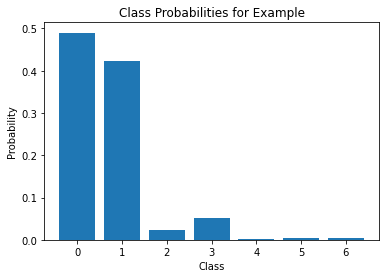

Correct Class Label: 0


In [12]:
import matplotlib.pyplot as plt

# Choose a specific example index for analysis
example_index = 0  # You can change this to any index

# Retrieve the example data
example_X, example_y = test_dataset[example_index]

# Forward pass to get class probabilities
model.eval()
with torch.no_grad():
    output = model(example_X.unsqueeze(0))  # Unsqueeze to add a batch dimension
    predicted_class = output.argmax()
    class_probs = torch.softmax(output, dim=1).squeeze().numpy()

# Get the correct class label (ground truth)
correct_class_label = example_y.item()

# Plot the class probabilities
class_labels = range(num_classes)
plt.bar(class_labels, class_probs, tick_label=class_labels)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Class Probabilities for Example')
plt.show()

# Print the correct class label
print(f"Correct Class Label: {correct_class_label}")


This code selects a specific example from the test data, calculates class probabilities, and plots them in a bar chart. It also indicates the correct class label for the example. Analyzing misclassifications and examining class probabilities can provide insights into model performance and areas for improvement.

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


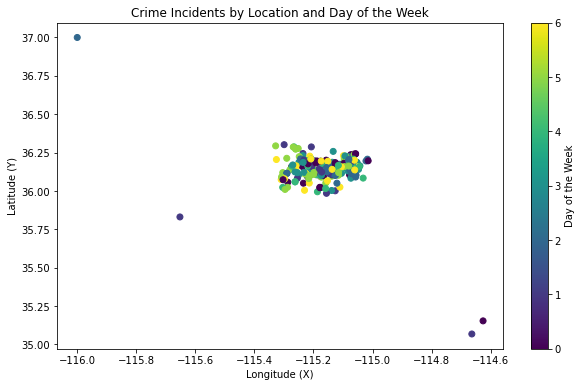

In [13]:
import matplotlib.pyplot as plt

# Scatter plot using coordinates, with color indicating the day of the week
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis')
plt.colorbar(label='Day of the Week')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Location and Day of the Week')
plt.show()


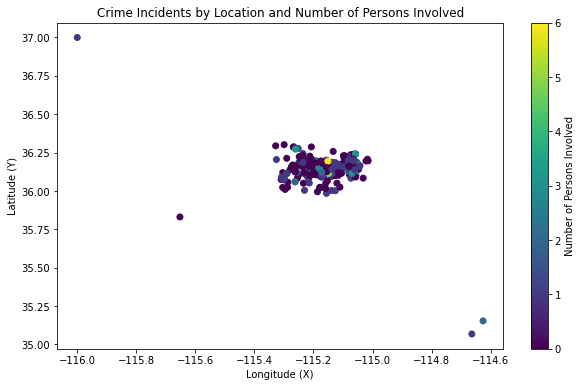

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis')
plt.colorbar(label='Number of Persons Involved')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Location and Number of Persons Involved')
plt.show()


In [15]:
import numpy as np
import pandas as pd

# Group the data by day of the week and count the number of crimes for each day
crime_count_by_day = df['DayOfWeek'].value_counts().sort_index()

# Create a DataFrame to display the results
crime_count_df = pd.DataFrame({'DayOfWeek': crime_count_by_day.index, 'CrimeCount': crime_count_by_day.values})

# Sort the DataFrame by crime count in descending order to find the most frequent days
most_frequent_days = crime_count_df.sort_values(by='CrimeCount', ascending=False)

# Print the most frequent days
print("Most Frequent Days for Crimes:")
print(most_frequent_days)


Most Frequent Days for Crimes:
   DayOfWeek  CrimeCount
4          4          51
3          3          44
5          5          43
0          0          40
1          1          37
2          2          32
6          6          28
